# Fitting with automatically obtained Jacobian

Fitting functions works in python primarily with scipy's [curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html), which is essentially a wrapper around several non-linear least squares minimizers. By defaut, it engages the [leastsq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html) function, which it itself a wrapper around [minpack](http://www.netlib.org/minpack/).

For the minimization, the derivative of the residuals with respect to the fitting parameters (Jacobian) has to be estimated. However, fits converge better if the Jacobian is analytically known. Of course you can derive it by hand or ask Wolfram Alpha, but it would be to have automatic differentiation in the fitting framework.

Automatic computation of derivatives (autograd) is widely used in the deep learning community, and we can use the tools made for neural networks for our fitting purposes. Some libraries like [autograd](https://github.com/HIPS/autograd) focus solely on the the automatic differentiation functionality, while other solutions like [pytorch](https://github.com/pytorch/pytorch) are much larger frameworks.

In geeksw, it is possible to exploit the autograd feature of pytorch (the library I am more familiar with) to easily get the Jacobian of any fitting function. A function `geeksw.fitting.utils` is provided, which takes any function that can be evaluated with both numpy arrays or pytorch tensors. Let's try it out!

Start with the imports needed for random number generation, plotting and fitting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

We import the [wrap_jac](https://github.com/guitargeek/geeksw/blob/master/geeksw/fitting/utils.py#L4) function from geeksw. In order to build fitting functions which are both compatible with pytorch and numpy, we import a little wrapper around the two of them: [geeksw.nptorch](https://github.com/guitargeek/geeksw/blob/master/geeksw/nptorch.py). Is provies all the mathematical functions which are included in both numpy and pytorch (`sin`, `cos`, `exp`, `sqrt`, etc.) and passes the inputs to either the numpy or pytorch version depending on the input type.

In [2]:
from geeksw.fitting.utils import wrap_jac
import geeksw.nptorch as nt

Define the true parameters of our toy model:

In [3]:
p = np.array([90., 5, 100])

This is the function according to which the data is distributed. We will also use it for fitting.

In [4]:
def f(x, mu, sigma, tau):
    sig = nt.exp(-(x - mu)**2/(2*sigma**2))
    bkg = nt.exp(-(x - mu)/tau)
    return sig + bkg

Generate the data, include some Gaussian noise.

In [5]:
x = np.linspace(60, 120, 100)
y = f(x, *p) + np.random.normal(0, 0.1, size=100)

Starting parameters for the fit:

In [6]:
p0 = [85., 1., 10]

Let's try it out without the analytic Jacobian:

In [7]:
%%time
popt_scipy, pcov_scipy = curve_fit(f, x, y, p0=p0)

CPU times: user 4.06 ms, sys: 94 µs, total: 4.16 ms
Wall time: 4.74 ms


Not with the Jacobian:

In [8]:
%%time
popt_jac, pcov_jac = curve_fit(f, x, y, p0=p0,  jac=wrap_jac(f))

CPU times: user 11.7 ms, sys: 655 µs, total: 12.4 ms
Wall time: 25 ms


We compare the fits to the data and to the true function:

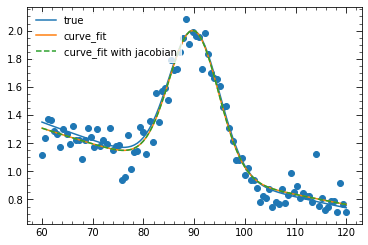

In [9]:
plt.scatter(x, y)
plt.plot(x, f(x, *p), label="true")
plt.plot(x, f(x, *popt_scipy), '-', label="curve_fit")
plt.plot(x, f(x, *popt_jac), '--', label="curve_fit with jacobian")
plt.legend(loc="upper left")
plt.show()

In out easy example, both fits converged well. The Jacobian version is just a bit slower due to the overhead from pytorch and the autograd.

It would be interesting to know from more complicated examples, if including the Jacobian can make the difference between convergence and non-convergence! Please let me know if you have data that you can't fit with `curve_fit` without the Jacobian, and tell me if including the Jacobian did help.

The open question is of course: did including the Jacobian make actually any difference in the example above? To find out what's happening, to hack around a little bit such that everytime the minimizer calls the numpy version of the function (that is not the Jacobian), the sum of squared residuals will be appended to an array which we will inspect later.

In [10]:
sum_of_squares = []

def f(x, mu, sigma, tau):
    sig = nt.exp(-(x - mu)**2/(2*sigma**2))
    bkg = nt.exp(-(x - mu)/tau)
    res = sig + bkg
    if isinstance(x, np.ndarray):
        sum_of_squares.append(np.sum((res - y)**2))
    return res

curve_fit(f, x, y, p0=p0)
sum_of_squares_nojac = np.array(sum_of_squares)

sum_of_squares = []
curve_fit(f, x, y, p0=p0,  jac=wrap_jac(f))
sum_of_squares_jac = np.array(sum_of_squares)

In [11]:
print("Function calls without using Jacobian: " + str(len(sum_of_squares_nojac)))
print("Function calls with Jacobian: " + str(len(sum_of_squares_jac)))

Function calls without using Jacobian: 39
Function calls with Jacobian: 12


Indeed, there was a difference and with the Jacobian, `curve_fit` needed about 3 times less calls to come to result it was happy with. Let's compare how the residues evolve:

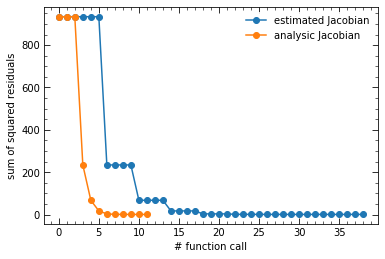

In [12]:
plt.plot(sum_of_squares_nojac, 'o-', label="estimated Jacobian")
plt.plot(sum_of_squares_jac, 'o-', label="analysic Jacobian")
plt.ylabel("sum of squared residuals")
plt.xlabel("# function call")
plt.legend(loc="upper right")
plt.show()

That is about what was expected. To estimate the Jacobian, one needs one additional call per parameter, because the parameters will be slightly varied one at a time to estimate the derivatives. With the analysic Jacobian available, this is not necessary. The two extra calls in the beginning give also a little plateau to the residue curve where the Jacobian was used, which must be somehow related to the details of the algorithm in the beginning.